<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

Importing Libraries:

In [1]:
### LIBRARIES

import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelBinarizer
import seaborn as sns
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.datasets import cifar10
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Conv2D, Dense, MaxPooling2D, BatchNormalization, Flatten, Dropout
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix

Unpickling and reading the data:

In [2]:
# Load CIFAR-10 dataset from tensorflow
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 14s 0us/step


Defining Classes & Functions:

In [3]:
### CLASSES

class preprocessing_setting:
    def __init__(self, normalization, augmentation):
        self.normalization = normalization
        self.augmentation = augmentation



In [4]:
### FUNCTIONS

def preprocess_1(data, setting):
# Normalization
    if setting.normalization == 'Min-Max Scaling':
        data_normalized = (data - tf.reduce_min(data)) / (tf.reduce_max(data) - tf.reduce_min(data))
    else:
        data1 = tf.cast(data, tf.float32)
        mean, variance = tf.nn.moments(data1, axes=[0, 1, 2])
        data_normalized = (data1 - mean) / tf.sqrt(variance)

# Augmentation
    datagen = ImageDataGenerator()

    if "Hue" in setting.augmentation:
        datagen.preprocessing_function = lambda img: tf.image.random_hue(img, 0.08)

    if "Brightness" in setting.augmentation:
        datagen.brightness_range = [0.8, 1.2]

    if "Contrast" in setting.augmentation:
        datagen.preprocessing_function = lambda img: tf.image.random_contrast(img, 0.8, 1.2)

    augmented_data_generator = datagen.flow(data_normalized, batch_size=len(data_normalized), shuffle=False)
    augmented_data = next(augmented_data_generator)

    return augmented_data

#---

def preprocess_2(data, setting):
# Normalization
    if setting.normalization == 'Min-Max Scaling':
        data_normalized = (data - tf.reduce_min(data)) / (tf.reduce_max(data) - tf.reduce_min(data))
    else:
        data1 = tf.cast(data, tf.float32)
        mean, variance = tf.nn.moments(data1, axes=[0, 1, 2])
        data_normalized = (data1 - mean) / tf.sqrt(variance)

# Augmentation
    datagen = ImageDataGenerator()

    if "Hue" in setting.augmentation:
        datagen.preprocessing_function = lambda img: tf.image.random_hue(img, 0.12)

    if "Brightness" in setting.augmentation:
        datagen.brightness_range = [1.8, 3.6]

    if "Contrast" in setting.augmentation:
        datagen.preprocessing_function = lambda img: tf.image.random_contrast(img, 1, 2.5)

    augmented_data_generator = datagen.flow(data_normalized, batch_size=len(data_normalized), shuffle=False)
    augmented_data = next(augmented_data_generator)

    return augmented_data

# #---

def preprocess_3(data, setting):
#     global augmented_data

# Normalization
    if setting.normalization == 'Min-Max Scaling':
        data_normalized = (data - tf.reduce_min(data)) / (tf.reduce_max(data) - tf.reduce_min(data))
    else:
        data1 = tf.cast(data, tf.float32)
        mean, variance = tf.nn.moments(data1, axes=[0, 1, 2])
        data_normalized = (data1 - mean) / tf.sqrt(variance)

# Augmentation
    datagen = ImageDataGenerator()

    if "Hue" in setting.augmentation:
        datagen.preprocessing_function = lambda img: tf.image.random_hue(img, 0.19)

    if "Brightness" in setting.augmentation:
        datagen.brightness_range = [3.0, 4.2]

    if "Contrast" in setting.augmentation:
        datagen.preprocessing_function = lambda img: tf.image.random_contrast(img, 2.8, 3.2)

    augmented_data_generator = datagen.flow(data_normalized, batch_size=len(data_normalized), shuffle=False)
    augmented_data = next(augmented_data_generator)

    return augmented_data

# #---

Plotting the first 3 images from each class:

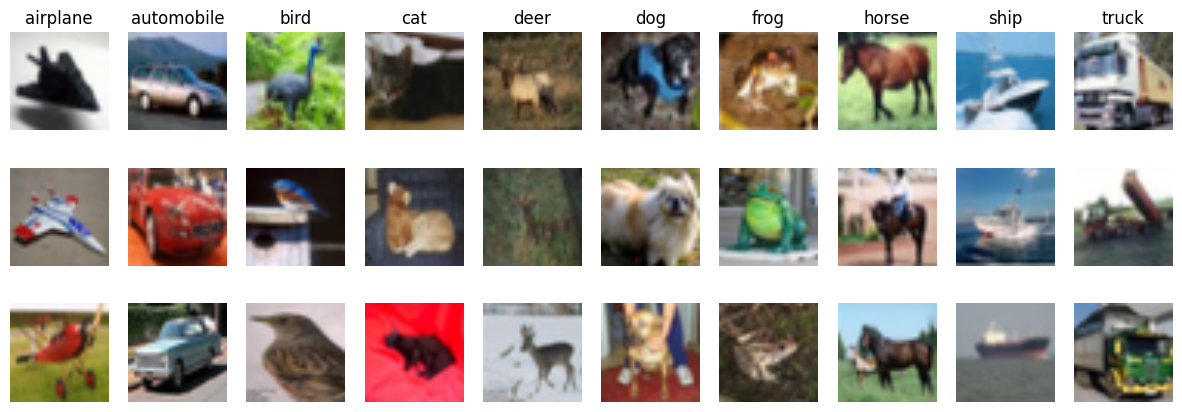

In [5]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(class_names)


plt.figure(figsize=(15, 5))
for cls in range(num_classes):
    idxs = np.where(Y_train == cls)[0][:3]
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + cls + 1
        plt.subplot(3, num_classes, plt_idx)
        plt.imshow(X_train[idx], interpolation='bilinear') #interpolation to smoothen the pixelation
        plt.axis('off')
        if i == 0:
            plt.title(class_names[cls])
plt.show()

Training data shape: (50000, 32, 32, 3)
Training labels shape: (50000, 1)
Testing data shape: (10000, 32, 32, 3)
Testing labels shape: (10000, 1)


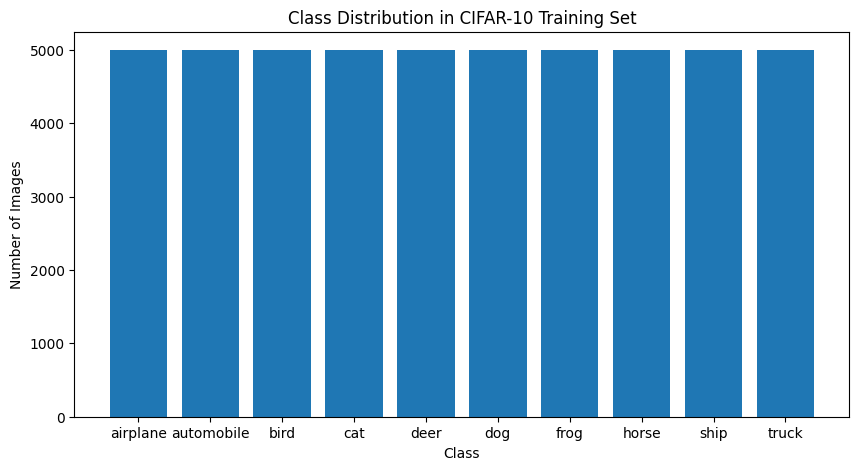

Missing values in the training set: 0


In [6]:
print(f'Training data shape: {X_train.shape}')
print(f'Training labels shape: {Y_train.shape}')
print(f'Testing data shape: {X_test.shape}')
print(f'Testing labels shape: {Y_test.shape}')

class_counts = np.bincount(Y_train.flatten())
plt.figure(figsize=(10, 5))
plt.bar(range(10), class_counts, tick_label=class_names)
plt.title('Class Distribution in CIFAR-10 Training Set')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

missing_values_train = np.isnan(X_train).sum() + np.isnan(Y_train).sum()
print(f"Missing values in the training set: {missing_values_train}")


In [7]:
# Check for missing values in the testing set
missing_values_test = np.isnan(X_test).sum() + np.isnan(Y_test).sum()
print(f"Missing values in the testing set: {missing_values_test}")

Missing values in the testing set: 0


Defining the different setting combinations for X preprocessing and categorizing Y:

In [8]:

settings = [
    preprocessing_setting(normalization='Min-Max Scaling', augmentation=['Brightness']),
    preprocessing_setting(normalization='Min-Max Scaling', augmentation=['Brightness', 'Contrast']),
    preprocessing_setting(normalization='Min-Max Scaling', augmentation=['Brightness', 'Hue']),
    preprocessing_setting(normalization='Min-Max Scaling', augmentation=['Contrast']),
    preprocessing_setting(normalization='Min-Max Scaling', augmentation=['Hue']),
    preprocessing_setting(normalization='Min-Max Scaling', augmentation=['Hue', 'Brightness', 'Contrast']),
    preprocessing_setting(normalization='Min-Max Scaling', augmentation=['Hue', 'Contrast']),
    preprocessing_setting(normalization='Standardization', augmentation=['Brightness']),
    preprocessing_setting(normalization='Standardization', augmentation=['Brightness', 'Contrast']),
    preprocessing_setting(normalization='Standardization', augmentation=['Brightness', 'Hue']),
    preprocessing_setting(normalization='Standardization', augmentation=['Contrast']),
    preprocessing_setting(normalization='Standardization', augmentation=['Hue']),
    preprocessing_setting(normalization='Standardization', augmentation=['Hue', 'Brightness', 'Contrast']),
    preprocessing_setting(normalization='Standardization', augmentation=['Hue', 'Contrast'])
]

Y_train = to_categorical(Y_train, num_classes=10)
Y_test = to_categorical(Y_test, num_classes=10)

**Testing CNN Models via iterations on the different preprocessors and settings:**

Model 1:

In [ ]:
def convolutional_model_1():

    # create model
    model = Sequential()
    model.add(Conv2D(16, (5, 5), activation='relu', input_shape=(32, 32, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2)))

    #Conv 2
    model.add(Conv2D(8, (2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Flatten())
    #Dense layer
    model.add(Dense(100, activation='relu'))

    #Final layer
    model.add(Dense(10, activation='softmax'))

    # Compile model
    model.compile(optimizer='adam', loss='categorical_crossentropy',  metrics=['accuracy'])
    return model

In [ ]:
# Iteration test: Model 1 / Preprocess 1

for i, setting in enumerate(settings):
    print(f"Running model with setting {i + 1}: {setting.normalization}, {setting.augmentation}")

    # Preprocess the data
    X_train_preprocessed = preprocess_1(X_train, setting)
    X_test_preprocessed = preprocess_1(X_test, setting)

    # Build the model
    model = convolutional_model_1()
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Fit the model
    model.fit(X_train_preprocessed, Y_train, validation_data=(X_test_preprocessed, Y_test), epochs=100, batch_size=40, callbacks=[early_stopping])

    # Evaluate the model
    scores = model.evaluate(X_test_preprocessed, Y_test)
    print(f"Setting {i + 1} - Accuracy: {scores[1] * 100:.2f}% \nError: {100 - scores[1] * 100:.2f}%")

In [ ]:
# Iteration test: Model 1 / Preprocess 2

for i, setting in enumerate(settings):
    print(f"Running model with setting {i + 1}: {setting.normalization}, {setting.augmentation}")

    # Preprocess the data
    X_train_preprocessed = preprocess_2(X_train, setting)
    X_test_preprocessed = preprocess_2(X_test, setting)

    # Build the model
    model = convolutional_model_1()
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Fit the model
    model.fit(X_train_preprocessed, Y_train, validation_data=(X_test_preprocessed, Y_test), epochs=100, batch_size=40, callbacks=[early_stopping])

    # Evaluate the model
    scores = model.evaluate(X_test_preprocessed, Y_test)
    print(f"Setting {i + 1} - Accuracy: {scores[1] * 100:.2f}% \nError: {100 - scores[1] * 100:.2f}%")

In [ ]:
# Iteration test: Model 1 / Preprocess 3

for i, setting in enumerate(settings):
    print(f"Running model with setting {i + 1}: {setting.normalization}, {setting.augmentation}")

    # Preprocess the data
    X_train_preprocessed = preprocess_3(X_train, setting)
    X_test_preprocessed = preprocess_3(X_test, setting)

    # Build the model
    model = convolutional_model_1()
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Fit the model
    model.fit(X_train_preprocessed, Y_train, validation_data=(X_test_preprocessed, Y_test), epochs=100, batch_size=40, callbacks=[early_stopping])

    # Evaluate the model
    scores = model.evaluate(X_test_preprocessed, Y_test)
    print(f"Setting {i + 1} - Accuracy: {scores[1] * 100:.2f}% \nError: {100 - scores[1] * 100:.2f}%")

Model 2:

In [ ]:
def convolutional_model_2():

    # create model
    model = Sequential()
    model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2)))
    model.add(Dropout(0.2))
    #Conv 2
    model.add(Conv2D(32, (2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.2))
    #Conv 3
    model.add(Conv2D(64, (2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())

    #Dense layer
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))

    #Final layer
    model.add(Dense(10, activation='softmax'))

    # Compile model
    model.compile(optimizer='adam', loss='categorical_crossentropy',  metrics=['accuracy'])
    return model


In [ ]:
# Iteration test: Model 2 / Preprocess 1

for i, setting in enumerate(settings):
    print(f"Running model with setting {i + 1}: {setting.normalization}, {setting.augmentation}")

    # Preprocess the data
    X_train_preprocessed = preprocess_1(X_train, setting)
    X_test_preprocessed = preprocess_1(X_test, setting)

    # Build the model
    model = convolutional_model_2()
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Fit the model
    model.fit(X_train_preprocessed, Y_train, validation_data=(X_test_preprocessed, Y_test), epochs=100, batch_size=40, callbacks=[early_stopping])

    # Evaluate the model
    scores = model.evaluate(X_test_preprocessed, Y_test)
    print(f"Setting {i + 1} - Accuracy: {scores[1] * 100:.2f}% \nError: {100 - scores[1] * 100:.2f}%")

Running model with setting 1: Min-Max Scaling, ['Hue', 'Contrast']
Epoch 1/100
1250/1250 [==============================] - 7s 4ms/step - loss: 1.6958 - accuracy: 0.3784 - val_loss: 1.4198 - val_accuracy: 0.4931
Epoch 2/100
1250/1250 [==============================] - 5s 4ms/step - loss: 1.4196 - accuracy: 0.4883 - val_loss: 1.2413 - val_accuracy: 0.5635
Epoch 3/100
1250/1250 [==============================] - 5s 4ms/step - loss: 1.3005 - accuracy: 0.5353 - val_loss: 1.1740 - val_accuracy: 0.5902
Epoch 4/100
1250/1250 [==============================] - 5s 4ms/step - loss: 1.2242 - accuracy: 0.5641 - val_loss: 1.1448 - val_accuracy: 0.6038
Epoch 5/100
1250/1250 [==============================] - 5s 4ms/step - loss: 1.1631 - accuracy: 0.5856 - val_loss: 1.1059 - val_accuracy: 0.6101
Epoch 6/100
1250/1250 [==============================] - 5s 4ms/step - loss: 1.1219 - accuracy: 0.6034 - val_loss: 1.0993 - val_accuracy: 0.6077
Epoch 7/100
1250/1250 [==============================] - 5s 4ms

In [ ]:
# Iteration test: Model 2 / Preprocess 2

for i, setting in enumerate(settings):
    print(f"Running model with setting {i + 1}: {setting.normalization}, {setting.augmentation}")

    # Preprocess the data
    X_train_preprocessed = preprocess_2(X_train, setting)
    X_test_preprocessed = preprocess_2(X_test, setting)

    # Build the model
    model = convolutional_model_2()
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Fit the model
    model.fit(X_train_preprocessed, Y_train, validation_data=(X_test_preprocessed, Y_test), epochs=100, batch_size=40, callbacks=[early_stopping])

    # Evaluate the model
    scores = model.evaluate(X_test_preprocessed, Y_test)
    print(f"Setting {i + 1} - Accuracy: {scores[1] * 100:.2f}% \nError: {100 - scores[1] * 100:.2f}%")

Running model with setting 1: Min-Max Scaling, ['Hue', 'Contrast']
Epoch 1/100
1250/1250 [==============================] - 9s 6ms/step - loss: 1.7033 - accuracy: 0.3772 - val_loss: 1.4077 - val_accuracy: 0.5061
Epoch 2/100
1250/1250 [==============================] - 5s 4ms/step - loss: 1.3913 - accuracy: 0.5023 - val_loss: 1.2449 - val_accuracy: 0.5656
Epoch 3/100
1250/1250 [==============================] - 5s 4ms/step - loss: 1.2659 - accuracy: 0.5503 - val_loss: 1.1172 - val_accuracy: 0.6099
Epoch 4/100
1250/1250 [==============================] - 5s 4ms/step - loss: 1.1951 - accuracy: 0.5735 - val_loss: 1.1124 - val_accuracy: 0.6051
Epoch 5/100
1250/1250 [==============================] - 5s 4ms/step - loss: 1.1396 - accuracy: 0.5942 - val_loss: 1.0143 - val_accuracy: 0.6472
Epoch 6/100
1250/1250 [==============================] - 5s 4ms/step - loss: 1.0942 - accuracy: 0.6130 - val_loss: 0.9677 - val_accuracy: 0.6653
Epoch 7/100
1250/1250 [==============================] - 5s 4ms

In [ ]:
# Iteration test: Model 2 / Preprocess 3

for i, setting in enumerate(settings):
    print(f"Running model with setting {i + 1}: {setting.normalization}, {setting.augmentation}")

    # Preprocess the data
    X_train_preprocessed = preprocess_3(X_train, setting)
    X_test_preprocessed = preprocess_3(X_test, setting)

    # Build the model
    model = convolutional_model_2()
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Fit the model
    model.fit(X_train_preprocessed, Y_train, validation_data=(X_test_preprocessed, Y_test), epochs=100, batch_size=40, callbacks=[early_stopping])

    # Evaluate the model
    scores = model.evaluate(X_test_preprocessed, Y_test)
    print(f"Setting {i + 1} - Accuracy: {scores[1] * 100:.2f}% \nError: {100 - scores[1] * 100:.2f}%")

Running model with setting 1: Min-Max Scaling, ['Hue', 'Contrast']
Epoch 1/100
1250/1250 [==============================] - 7s 4ms/step - loss: 1.6222 - accuracy: 0.4083 - val_loss: 1.3538 - val_accuracy: 0.5218
Epoch 2/100
1250/1250 [==============================] - 5s 4ms/step - loss: 1.3264 - accuracy: 0.5261 - val_loss: 1.1842 - val_accuracy: 0.5903
Epoch 3/100
1250/1250 [==============================] - 5s 4ms/step - loss: 1.2083 - accuracy: 0.5706 - val_loss: 1.0581 - val_accuracy: 0.6333
Epoch 4/100
1250/1250 [==============================] - 5s 4ms/step - loss: 1.1353 - accuracy: 0.5981 - val_loss: 1.0044 - val_accuracy: 0.6518
Epoch 5/100
1250/1250 [==============================] - 5s 4ms/step - loss: 1.0801 - accuracy: 0.6201 - val_loss: 0.9432 - val_accuracy: 0.6735
Epoch 6/100
1250/1250 [==============================] - 5s 4ms/step - loss: 1.0413 - accuracy: 0.6321 - val_loss: 0.9103 - val_accuracy: 0.6861
Epoch 7/100
1250/1250 [==============================] - 5s 4ms

Model 3:

In [ ]:
def convolutional_model_3():

    # create model
    model = Sequential()
    model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2)))
    model.add(Dropout(0.2))
    #Conv 2
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.25))
    #Conv 3
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.3))

    model.add(Flatten())

    #Dense layer
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.4))

    #Final layer
    model.add(Dense(10, activation='softmax'))

    # Compile model
    model.compile(optimizer='adam', loss='categorical_crossentropy',  metrics=['accuracy'])
    return model

In [ ]:
# Iteration test: Model 3 / Preprocess 1

for i, setting in enumerate(settings):
    print(f"Running model with setting {i + 1}: {setting.normalization}, {setting.augmentation}")

    # Preprocess the data
    X_train_preprocessed = preprocess_1(X_train, setting)
    X_test_preprocessed = preprocess_1(X_test, setting)

    # Build the model
    model = convolutional_model_3()
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Fit the model
    model.fit(X_train_preprocessed, Y_train, validation_data=(X_test_preprocessed, Y_test), epochs=100, batch_size=40, callbacks=[early_stopping])

    # Evaluate the model
    scores = model.evaluate(X_test_preprocessed, Y_test)
    print(f"Setting {i + 1} - Accuracy: {scores[1] * 100:.2f}% \nError: {100 - scores[1] * 100:.2f}%")

Running model with setting 1: Min-Max Scaling, ['Hue', 'Contrast']
Epoch 1/100
1250/1250 [==============================] - 9s 5ms/step - loss: 1.6293 - accuracy: 0.4247 - val_loss: 1.2950 - val_accuracy: 0.5443
Epoch 2/100
1250/1250 [==============================] - 6s 5ms/step - loss: 1.3013 - accuracy: 0.5359 - val_loss: 1.1374 - val_accuracy: 0.6058
Epoch 3/100
1250/1250 [==============================] - 6s 5ms/step - loss: 1.1714 - accuracy: 0.5896 - val_loss: 1.1157 - val_accuracy: 0.6000
Epoch 4/100
1250/1250 [==============================] - 6s 5ms/step - loss: 1.0820 - accuracy: 0.6194 - val_loss: 1.1623 - val_accuracy: 0.6168
Epoch 5/100
1250/1250 [==============================] - 6s 5ms/step - loss: 1.0155 - accuracy: 0.6465 - val_loss: 0.8328 - val_accuracy: 0.7112
Epoch 6/100
1250/1250 [==============================] - 6s 5ms/step - loss: 0.9700 - accuracy: 0.6619 - val_loss: 0.9961 - val_accuracy: 0.6701
Epoch 7/100
1250/1250 [==============================] - 6s 5ms

In [ ]:
# Iteration test: Model 3 / Preprocess 2

for i, setting in enumerate(settings):
    print(f"Running model with setting {i + 1}: {setting.normalization}, {setting.augmentation}")

    # Preprocess the data
    X_train_preprocessed = preprocess_2(X_train, setting)
    X_test_preprocessed = preprocess_2(X_test, setting)

    # Build the model
    model = convolutional_model_3()
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Fit the model
    model.fit(X_train_preprocessed, Y_train, validation_data=(X_test_preprocessed, Y_test), epochs=100, batch_size=40, callbacks=[early_stopping])

    # Evaluate the model
    scores = model.evaluate(X_test_preprocessed, Y_test)
    print(f"Setting {i + 1} - Accuracy: {scores[1] * 100:.2f}% \nError: {100 - scores[1] * 100:.2f}%")

Running model with setting 1: Min-Max Scaling, ['Hue', 'Contrast']
Epoch 1/100
1250/1250 [==============================] - 13s 5ms/step - loss: 1.6618 - accuracy: 0.4177 - val_loss: 1.4596 - val_accuracy: 0.5112
Epoch 2/100
1250/1250 [==============================] - 6s 5ms/step - loss: 1.3042 - accuracy: 0.5383 - val_loss: 1.1061 - val_accuracy: 0.6068
Epoch 3/100
1250/1250 [==============================] - 6s 5ms/step - loss: 1.1781 - accuracy: 0.5848 - val_loss: 1.0607 - val_accuracy: 0.6359
Epoch 4/100
1250/1250 [==============================] - 6s 5ms/step - loss: 1.0948 - accuracy: 0.6159 - val_loss: 0.9224 - val_accuracy: 0.6792
Epoch 5/100
1250/1250 [==============================] - 6s 5ms/step - loss: 1.0254 - accuracy: 0.6427 - val_loss: 0.9130 - val_accuracy: 0.6833
Epoch 6/100
1250/1250 [==============================] - 6s 5ms/step - loss: 0.9734 - accuracy: 0.6624 - val_loss: 1.2949 - val_accuracy: 0.6114
Epoch 7/100
1250/1250 [==============================] - 6s 5m

In [ ]:
# Iteration test: Model 3 / Preprocess 3

for i, setting in enumerate(settings):
    print(f"Running model with setting {i + 1}: {setting.normalization}, {setting.augmentation}")

    # Preprocess the data
    X_train_preprocessed = preprocess_3(X_train, setting)
    X_test_preprocessed = preprocess_3(X_test, setting)

    # Build the model
    model = convolutional_model_3()
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Fit the model
    model.fit(X_train_preprocessed, Y_train, validation_data=(X_test_preprocessed, Y_test), epochs=100, batch_size=40, callbacks=[early_stopping])

    # Evaluate the model
    scores = model.evaluate(X_test_preprocessed, Y_test)
    print(f"Setting {i + 1} - Accuracy: {scores[1] * 100:.2f}% \nError: {100 - scores[1] * 100:.2f}%")

Running model with setting 1: Min-Max Scaling, ['Hue', 'Contrast']
Epoch 1/100
1250/1250 [==============================] - 9s 5ms/step - loss: 1.5667 - accuracy: 0.4517 - val_loss: 1.4494 - val_accuracy: 0.5370
Epoch 2/100
1250/1250 [==============================] - 6s 5ms/step - loss: 1.2218 - accuracy: 0.5707 - val_loss: 1.1164 - val_accuracy: 0.6287
Epoch 3/100
1250/1250 [==============================] - 6s 5ms/step - loss: 1.1108 - accuracy: 0.6118 - val_loss: 0.9695 - val_accuracy: 0.6648
Epoch 4/100
1250/1250 [==============================] - 6s 5ms/step - loss: 1.0247 - accuracy: 0.6422 - val_loss: 0.9121 - val_accuracy: 0.6874
Epoch 5/100
1250/1250 [==============================] - 6s 5ms/step - loss: 0.9697 - accuracy: 0.6622 - val_loss: 0.8492 - val_accuracy: 0.7147
Epoch 6/100
1250/1250 [==============================] - 6s 5ms/step - loss: 0.9308 - accuracy: 0.6792 - val_loss: 0.8491 - val_accuracy: 0.7110
Epoch 7/100
1250/1250 [==============================] - 6s 5ms

Model 4:

In [ ]:
def convolutional_model_4():

    # create model
    model = Sequential()
    model.add(Conv2D(128, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2)))
    model.add(Dropout(0.3))
    #Conv 2
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.35))
    #Conv 3
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.4))

    model.add(Flatten())

    #Dense layer
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))

    #Final layer
    model.add(Dense(10, activation='softmax'))

    # Compile model
    model.compile(optimizer='adam', loss='categorical_crossentropy',  metrics=['accuracy'])
    return model


In [ ]:
# Iteration test: Model 4 / Preprocess 1

for i, setting in enumerate(settings):
    print(f"Running model with setting {i + 1}: {setting.normalization}, {setting.augmentation}")

    # Preprocess the data
    X_train_preprocessed = preprocess_1(X_train, setting)
    X_test_preprocessed = preprocess_1(X_test, setting)

    # Build the model
    model = convolutional_model_4()
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Fit the model
    model.fit(X_train_preprocessed, Y_train, validation_data=(X_test_preprocessed, Y_test), epochs=100, batch_size=40, callbacks=[early_stopping])

    # Evaluate the model
    scores = model.evaluate(X_test_preprocessed, Y_test)
    print(f"Setting {i + 1} - Accuracy: {scores[1] * 100:.2f}% \nError: {100 - scores[1] * 100:.2f}%")

Running model with setting 1: Min-Max Scaling, ['Brightness']
Epoch 1/100
1250/1250 [==============================] - 19s 13ms/step - loss: 2.6964 - accuracy: 0.1071 - val_loss: 2.3673 - val_accuracy: 0.1065
Epoch 2/100
1250/1250 [==============================] - 16s 12ms/step - loss: 2.3009 - accuracy: 0.1114 - val_loss: 2.2823 - val_accuracy: 0.1174
Epoch 3/100
1250/1250 [==============================] - 15s 12ms/step - loss: 2.2978 - accuracy: 0.1124 - val_loss: 2.2836 - val_accuracy: 0.1088
Epoch 4/100
1250/1250 [==============================] - 15s 12ms/step - loss: 2.2979 - accuracy: 0.1113 - val_loss: 2.2889 - val_accuracy: 0.1126
Epoch 5/100
313/313 [==============================] - 2s 4ms/step - loss: 2.2823 - accuracy: 0.1174
Setting 1 - Accuracy: 11.74% 
Error: 88.26%
Running model with setting 2: Min-Max Scaling, ['Brightness', 'Contrast']
Epoch 1/100
1250/1250 [==============================] - 18s 13ms/step - loss: 2.7258 - accuracy: 0.1091 - val_loss: 2.3199 - val_a

In [ ]:
# Iteration test: Model 4 / Preprocess 2

for i, setting in enumerate(settings):
    print(f"Running model with setting {i + 1}: {setting.normalization}, {setting.augmentation}")

    # Preprocess the data
    X_train_preprocessed = preprocess_2(X_train, setting)
    X_test_preprocessed = preprocess_2(X_test, setting)

    # Build the model
    model = convolutional_model_4()
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Fit the model
    model.fit(X_train_preprocessed, Y_train, validation_data=(X_test_preprocessed, Y_test), epochs=100, batch_size=40, callbacks=[early_stopping])

    # Evaluate the model
    scores = model.evaluate(X_test_preprocessed, Y_test)
    print(f"Setting {i + 1} - Accuracy: {scores[1] * 100:.2f}% \nError: {100 - scores[1] * 100:.2f}%")

Running model with setting 1: Min-Max Scaling, ['Brightness']
Epoch 1/100
1250/1250 [==============================] - 21s 12ms/step - loss: 2.5835 - accuracy: 0.1291 - val_loss: 2.2605 - val_accuracy: 0.1339
Epoch 2/100
1250/1250 [==============================] - 15s 12ms/step - loss: 2.2778 - accuracy: 0.1369 - val_loss: 2.2503 - val_accuracy: 0.1448
Epoch 3/100
1250/1250 [==============================] - 15s 12ms/step - loss: 2.2739 - accuracy: 0.1357 - val_loss: 2.2543 - val_accuracy: 0.1404
Epoch 4/100
1250/1250 [==============================] - 15s 12ms/step - loss: 2.2745 - accuracy: 0.1357 - val_loss: 2.2478 - val_accuracy: 0.1499
Epoch 5/100
1250/1250 [==============================] - 15s 12ms/step - loss: 2.2700 - accuracy: 0.1352 - val_loss: 2.2459 - val_accuracy: 0.1412
Epoch 6/100
1250/1250 [==============================] - 15s 12ms/step - loss: 2.2693 - accuracy: 0.1344 - val_loss: 2.2527 - val_accuracy: 0.1497
Epoch 7/100
1250/1250 [==============================] -

In [ ]:
# Iteration test: Model 4 / Preprocess 3

for i, setting in enumerate(settings):
    print(f"Running model with setting {i + 1}: {setting.normalization}, {setting.augmentation}")

    # Preprocess the data
    X_train_preprocessed = preprocess_3(X_train, setting)
    X_test_preprocessed = preprocess_3(X_test, setting)

    # Build the model
    model = convolutional_model_4()
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Fit the model
    model.fit(X_train_preprocessed, Y_train, validation_data=(X_test_preprocessed, Y_test), epochs=100, batch_size=40, callbacks=[early_stopping])

    # Evaluate the model
    scores = model.evaluate(X_test_preprocessed, Y_test)
    print(f"Setting {i + 1} - Accuracy: {scores[1] * 100:.2f}% \nError: {100 - scores[1] * 100:.2f}%")

Running model with setting 1: Min-Max Scaling, ['Brightness']
Epoch 1/100
1250/1250 [==============================] - 18s 13ms/step - loss: 2.6286 - accuracy: 0.1305 - val_loss: 2.2957 - val_accuracy: 0.1481
Epoch 2/100
1250/1250 [==============================] - 16s 13ms/step - loss: 2.2765 - accuracy: 0.1366 - val_loss: 2.2666 - val_accuracy: 0.1351
Epoch 3/100
1250/1250 [==============================] - 15s 12ms/step - loss: 2.2709 - accuracy: 0.1386 - val_loss: 2.2396 - val_accuracy: 0.1511
Epoch 4/100
1250/1250 [==============================] - 15s 12ms/step - loss: 2.2712 - accuracy: 0.1358 - val_loss: 2.2418 - val_accuracy: 0.1491
Epoch 5/100
1250/1250 [==============================] - 15s 12ms/step - loss: 2.2695 - accuracy: 0.1376 - val_loss: 2.2475 - val_accuracy: 0.1505
Epoch 6/100
313/313 [==============================] - 1s 3ms/step - loss: 2.2396 - accuracy: 0.1511
Setting 1 - Accuracy: 15.11% 
Error: 84.89%
Running model with setting 2: Min-Max Scaling, ['Brightnes

**Transfer Learning Model with no finetuning**
- VGG16


The model that performed the best out of all tested.

In [ ]:
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
x = Flatten()(base_model.output)
x = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, Y_train, epochs=10, batch_size=32, validation_data=(X_val, Y_val))

test_loss, test_accuracy = model.evaluate(X_test, Y_test)
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_test_classes = np.argmax(Y_test, axis=1)
f1 = f1_score(Y_test_classes, Y_pred_classes, average='macro')

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')
print(f'F1 Score: {f1}')


Graphs to plot training accuracy against validation accuracy and training loss against validation loss

In [ ]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

**Transfer Learning Model with finetuning**
- Four layers are trainable

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(datagen.flow(X_train, Y_train, batch_size=32),
                    epochs=50, validation_data=(X_val, Y_val), callbacks=[early_stopping])

for layer in base_model.layers[-4:]:
    layer.trainable = True

model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

fine_tune_epochs = 50
total_epochs = 50 + fine_tune_epochs

history_fine = model.fit(datagen.flow(X_train, Y_train, batch_size=32),
                         epochs=total_epochs, initial_epoch=50, validation_data=(X_val, Y_val), callbacks=[early_stopping])

test_loss, test_accuracy = model.evaluate(X_test, Y_test)
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_test_classes = np.argmax(Y_test, axis=1)
f1 = f1_score(Y_test_classes, Y_pred_classes, average='macro')

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')
print(f'F1 Score: {f1}')

Plot training and validation accuracy/loss values

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'] + history_fine.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'], label='val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'] + history_fine.history['loss'], label='train loss')
plt.plot(history.history['val_loss'] + history_fine.history['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

Choosing the best Model:

In [12]:
def convolutional_model_4():

    # create model
    model = Sequential()
    model.add(Conv2D(128, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2)))
    model.add(Dropout(0.3))
    #Conv 2
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.35))
    #Conv 3
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.4))

    model.add(Flatten())

    #Dense layer
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))

    #Final layer
    model.add(Dense(10, activation='softmax'))

    # Compile model
    model.compile(optimizer='adam', loss='categorical_crossentropy',  metrics=['accuracy'])
    return model



# Compile the model with the best performance leaving out the iteration.
# Preprocess the data
X_train_preprocessed = preprocess_3(X_train, settings[13])
X_test_preprocessed = preprocess_3(X_test, settings[13])

# Build the model
model = convolutional_model_4()
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)  ## Increased early stopping from iteration version

# Fit the model
history = model.fit(X_train_preprocessed, Y_train, validation_data=(X_test_preprocessed, Y_test), epochs=100, batch_size=40, callbacks=[early_stopping])

# Evaluate the model
scores = model.evaluate(X_test_preprocessed, Y_test)
print(f"Setting {i + 1} - Accuracy: {scores[1] * 100:.2f}% \nError: {100 - scores[1] * 100:.2f}%")


Epoch 1/100
1250/1250 [==============================] - 18s 12ms/step - loss: 1.6371 - accuracy: 0.4453 - val_loss: 1.2424 - val_accuracy: 0.5624
Epoch 2/100
1250/1250 [==============================] - 15s 12ms/step - loss: 1.2357 - accuracy: 0.5701 - val_loss: 0.9663 - val_accuracy: 0.6625
Epoch 3/100
1250/1250 [==============================] - 15s 12ms/step - loss: 1.0946 - accuracy: 0.6250 - val_loss: 0.8903 - val_accuracy: 0.6899
Epoch 4/100
1250/1250 [==============================] - 15s 12ms/step - loss: 1.0068 - accuracy: 0.6563 - val_loss: 0.8324 - val_accuracy: 0.7128
Epoch 5/100
1250/1250 [==============================] - 15s 12ms/step - loss: 0.9396 - accuracy: 0.6803 - val_loss: 0.7742 - val_accuracy: 0.7401
Epoch 6/100
1250/1250 [==============================] - 15s 12ms/step - loss: 0.8820 - accuracy: 0.7021 - val_loss: 0.7703 - val_accuracy: 0.7400
Epoch 7/100
1250/1250 [==============================] - 15s 12ms/step - loss: 0.8350 - accuracy: 0.7133 - val_loss: 0

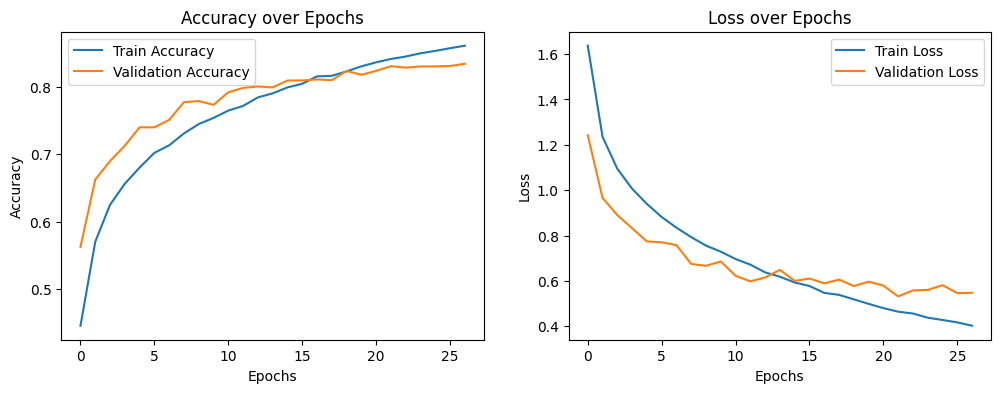

In [13]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.show()

313/313 [==============================] - 1s 2ms/step


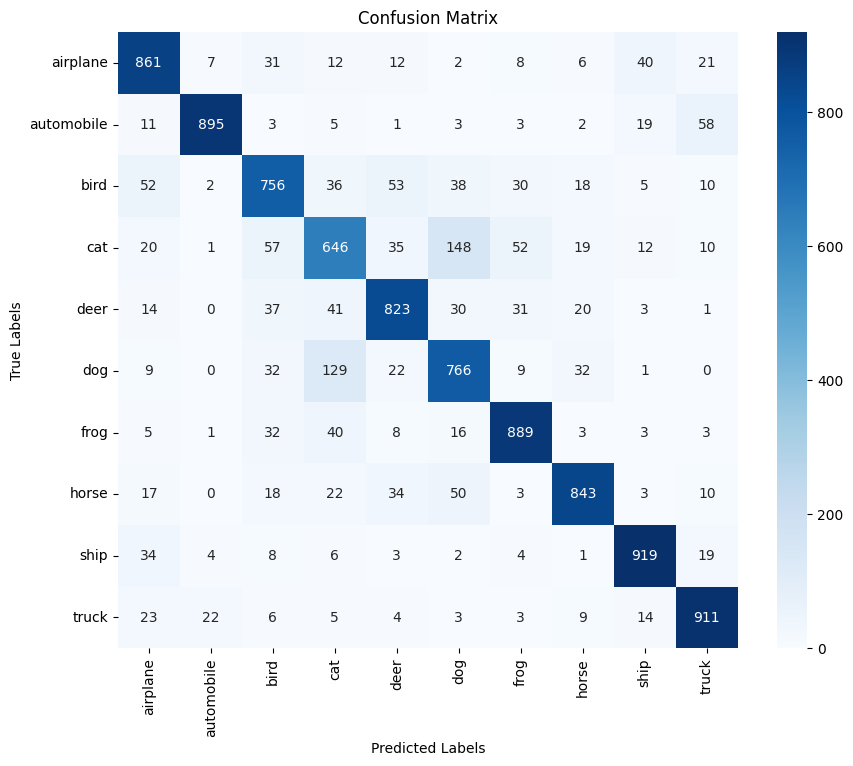

In [14]:
Y_pred = model.predict(X_test_preprocessed)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_test, axis=1)

conf_matrix = confusion_matrix(Y_true, Y_pred_classes)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Save the model in the SavedModel format
save_path = '/content/project-1-model_4_p3_s14_saved_model/1'
tf.saved_model.save(model, save_path)

# Download the model
!zip -r /content/project-1-model_4_p3_s14_saved_model.zip /content/project-1-model_4_p3_s14_saved_model

from google.colab import files
files.download('/content/project-1-model_4_p3_s14_saved_model.zip')

In [16]:
#Calculating Mean & Variance for app.py usage

def m_v(data1, data2):
# Normalization

  data = np.concatenate((data1, data2), axis=0)
  data = tf.cast(data, tf.float32)
  mean, variance = tf.nn.moments(data, axes=[0, 1, 2])

  return print(mean, variance)

m_v(X_train, X_test)

tf.Tensor([125.42654  123.07675  114.030205], shape=(3,), dtype=float32) tf.Tensor([3966.1855 3851.9634 4449.7007], shape=(3,), dtype=float32)
